In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
from keras.utils import normalize
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from matplotlib.patches import Rectangle

SIZE_X = 128
SIZE_Y = 128
n_channels = 3
n_classes = 10
Batch_size = 16
EPOCHS = 30
MODEL = 'unet'
activation = 'softmax'
BACKBONE = 'efficientnetb7'
encoder_weights = 'imagenet'
parent_directory = r'/content/drive/MyDrive/Post-Flood Disaster Management/UNET(patches)'

In [2]:
%cd '/content/drive/MyDrive/Post-Flood Disaster Management/UNET(patches)'
%ls

/content/drive/.shortcut-targets-by-id/1_b4qbpFZKQVKR45o506yBbBs9kuahEZC/Post-Flood Disaster Management/UNET(patches)
 dataset/  'U-Net(efficientnetb7).ipynb'


In [3]:
def load_images(parent_directory, split='train'):
    images = []
    masks = []

    image_folder_path = f'{parent_directory}/{split}/{split}-org-img'
    for folders in tqdm(os.listdir(image_folder_path)):
        for img_path in glob.glob(os.path.join(f'{image_folder_path}/{folders}', "*.jpg")):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (SIZE_Y, SIZE_X))
            images.append(img)

            mask_path = (img_path.replace('org', 'label')).replace('jpg', 'png')
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    print(f'{split.upper()}: Images loaded: {images.shape[0]}')
    print(f'{split.upper()}: Masks loaded: {masks.shape[0]}')

    return images, masks

In [4]:
def preprocess_data(images, masks, unet_preporcessing):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)

    masks = np.expand_dims(masks, axis=-1)
    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], n_classes))

    return images, masks

In [5]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}

color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128],
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]
    return label_seg

def display_images_with_masks(image, mask, predicted):
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3))))
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [ ]:
#Load the images
train_images, train_masks = load_images(parent_directory, split='train')
val_images, val_masks = load_images(parent_directory, split='val')

100%|██████████| 1445/1445 [15:07<00:00,  1.59it/s]


TRAIN: Images loaded: 50575
TRAIN: Masks loaded: 50575


100%|██████████| 450/450 [04:47<00:00,  1.57it/s]


VAL: Images loaded: 15750
VAL: Masks loaded: 15750


In [ ]:
data_to_save = {
    'train_images': train_images,
    'train_masks': train_masks,
    'val_images': val_images,
    'val_masks': val_masks
}

pickle_file_path = f'dataset/train_and_val_data({SIZE_X}x{SIZE_Y})patch(1000x1000).pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

val_seperate_images = val_images
val_seperate_masks = val_masks

Data saved to dataset/train_and_val_data(128x128).pickle
Shapes of loaded data:
Train Images: (50575, 128, 128, 3)
Train Masks: (50575, 128, 128)
Val Images: (15750, 128, 128, 3)
Val Masks: (15750, 128, 128)


In [6]:
pickle_file_path = f'dataset/train_and_val_data({SIZE_X}x{SIZE_Y})patch(1000x1000).pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

train_images = loaded_data['train_images']
train_masks = loaded_data['train_masks']
val_images = loaded_data['val_images']
val_masks = loaded_data['val_masks']

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

val_seperate_images = val_images
val_seperate_masks = val_masks

Shapes of loaded data:
Train Images: (17340, 128, 128, 3)
Train Masks: (17340, 128, 128)
Val Images: (5400, 128, 128, 3)
Val Masks: (5400, 128, 128)


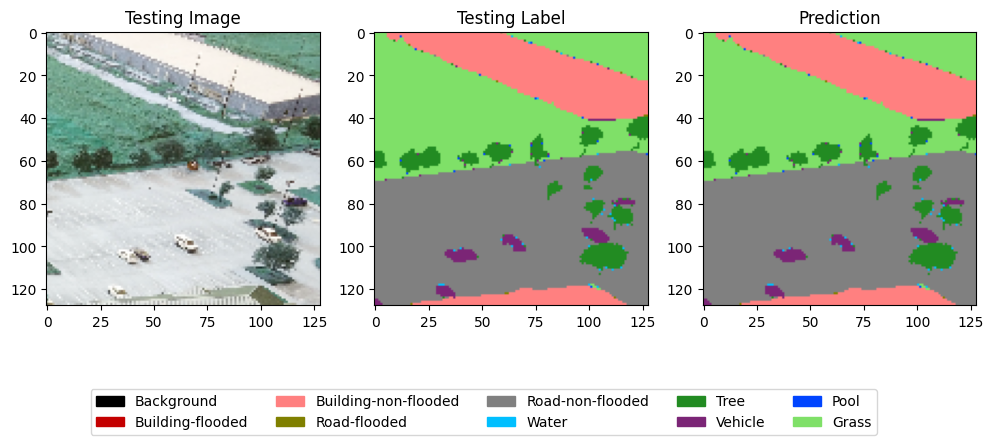

In [11]:
num = np.random.randint(0, len(train_images))
display_images_with_masks(train_images[num], train_masks[num], train_masks[num])

In [14]:
!pip install segmentation_models

In [12]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

preprocess_input = sm.get_preprocessing(BACKBONE)

train_images, train_masks = preprocess_data(train_images, train_masks, preprocess_input)
val_images, val_masks = preprocess_data(val_images, val_masks, preprocess_input)

print('Shapes of loaded data:')
print('Train Images:', train_images.shape)
print('Train Masks:', train_masks.shape)
print('Val Images:', val_images.shape)
print('Val Masks:', val_masks.shape)

Segmentation Models: using `tf.keras` framework.
Shapes of loaded data:
Train Images: (17340, 128, 128, 3)
Train Masks: (17340, 128, 128, 10)
Val Images: (5400, 128, 128, 3)
Val Masks: (5400, 128, 128, 10)


In [13]:
if MODEL == 'unet':
    model = sm.Unet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'fpn':
    model = sm.FPN(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'pspnet':
    model = sm.PSPNet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'linknet':
    model = sm.Linknet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
else:
    raise ValueError('Unknown model')

model.compile('Adam', loss=sm.losses.jaccard_loss, metrics=[sm.metrics.iou_score])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 64, 64, 64)           1728      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 64, 64, 64)           256       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 64, 64, 64)           0         ['stem_bn[0][0]']         

In [14]:
history = model.fit(x=train_images, y=train_masks, batch_size=Batch_size, epochs=EPOCHS, validation_data=(val_images, val_masks))

Epoch 1/30
1084/1084 [==============================] - 337s 180ms/step - loss: 0.6401 - iou_score: 0.3600 - val_loss: 0.7340 - val_iou_score: 0.2661
Epoch 2/30
1084/1084 [==============================] - 182s 168ms/step - loss: 0.5499 - iou_score: 0.4501 - val_loss: 0.7197 - val_iou_score: 0.2804
Epoch 3/30
1084/1084 [==============================] - 181s 167ms/step - loss: 0.5261 - iou_score: 0.4740 - val_loss: 0.7174 - val_iou_score: 0.2827
Epoch 4/30
1084/1084 [==============================] - 181s 167ms/step - loss: 0.5196 - iou_score: 0.4804 - val_loss: 0.7185 - val_iou_score: 0.2815
Epoch 5/30
1084/1084 [==============================] - 182s 168ms/step - loss: 0.4988 - iou_score: 0.5012 - val_loss: 0.7201 - val_iou_score: 0.2800
Epoch 6/30
1084/1084 [==============================] - 181s 167ms/step - loss: 0.4910 - iou_score: 0.5090 - val_loss: 0.7050 - val_iou_score: 0.2951
Epoch 7/30
1084/1084 [==============================] - 181s 167ms/step - loss: 0.4817 - iou_score: 

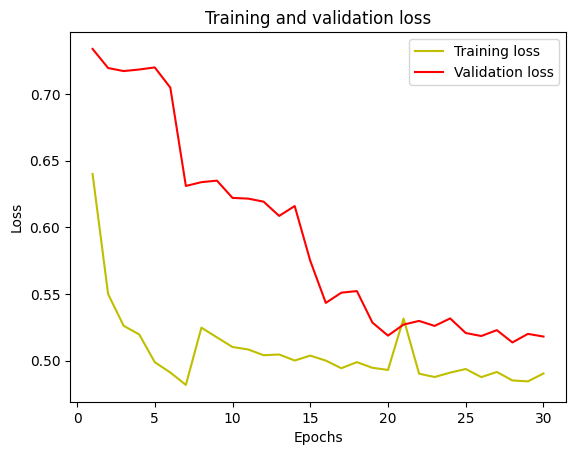

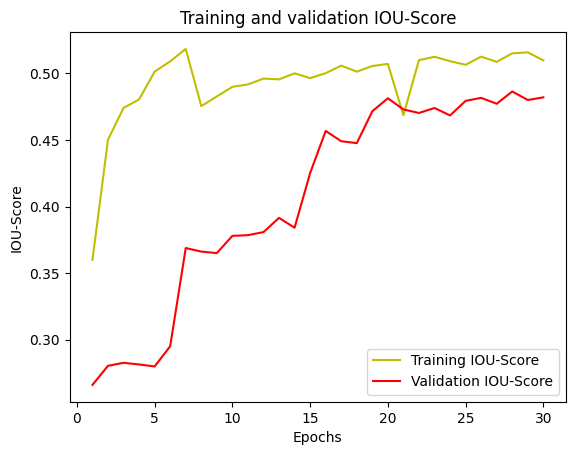

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU-Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU-Score')
plt.title('Training and validation IOU-Score')
plt.xlabel('Epochs')
plt.ylabel('IOU-Score')
plt.legend()
plt.show()

In [16]:
model.save(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()})-({SIZE_X}x{SIZE_Y})-Patch_(1000x1000).hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.load_weights(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()})-({SIZE_X}x{SIZE_Y})-Patch_(1000x1000).hdf5')

In [17]:
model.input_shape, model.output_shape

((None, 128, 128, 3), (None, 128, 128, 10))

In [ ]:
test_images, test_masks = load_images(parent_directory, split='test')
test_images_seperate = test_images

In [ ]:
data_to_save = {
    'test_images': test_images,
    'test_masks': test_masks,
    'test_images_seperate': test_images_seperate
}

pickle_file_path = f'../../dataset/test_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

In [18]:
pickle_file_path = f'dataset/test_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 128, 128, 3)
Test Masks: (448, 128, 128)


In [19]:
test_images, test_masks = preprocess_data(test_images, test_masks, preprocess_input)

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

Shapes of loaded data:
Test Images: (448, 128, 128, 3)
Test Masks: (448, 128, 128, 10)


## Test Evaluation and Perfomance

In [20]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  42.21113324165344 %


In [21]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)
predicted_masks = np.argmax(y_pred, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

print(predicted_masks.shape)
print(test_masks_.shape)

14/14 [==============================] - 5s 43ms/step
(448, 128, 128)
(448, 128, 128)


In [22]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    if i == 0:
        continue
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

mean_IoU_without_background = np.mean(class_IoUs)
print("Mean IoU (excluding Background):", mean_IoU_without_background)

Mean IoU = 0.4095778
IoU for each class:
Building Flooded: 0.0
Building Non-Flooded: 0.6241090297698975
Road Flooded: 0.2355373203754425
Road Non-Flooded: 0.654469907283783
Water: 0.5758758783340454
Tree: 0.6578807234764099
Vehicle: 0.12200485914945602
Pool: 0.3267225921154022
Grass: 0.7685962319374084
Mean IoU (excluding Background): 0.4405774


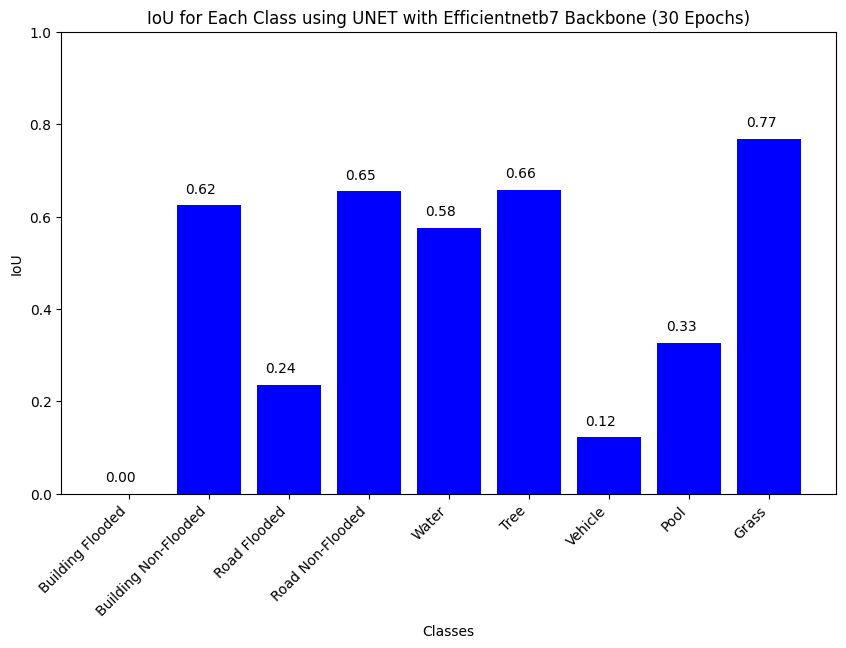

In [23]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names[1:], class_IoUs, color='blue')
plt.title(f'IoU for Each Class using {MODEL.upper()} with {BACKBONE.capitalize()} Backbone ({EPOCHS} Epochs)')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [24]:
def calculate_iou(ground_truth_mask, predicted_mask):
    intersection = np.logical_and(ground_truth_mask, predicted_mask)
    union = np.logical_or(ground_truth_mask, predicted_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [25]:
iou_of_each_image = {}
for i in range(len(test_images)):
    iou = calculate_iou(test_masks_[i], predicted_masks[i])
    iou_of_each_image[i] = iou

## Samples Visualization

In [26]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    image = test_images_seperate[image_id]
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    iou = calculate_iou(ground_truth_mask, predicted_mask)
    print(f'IoU for this image: {iou}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)
IoU for this image: 1.0


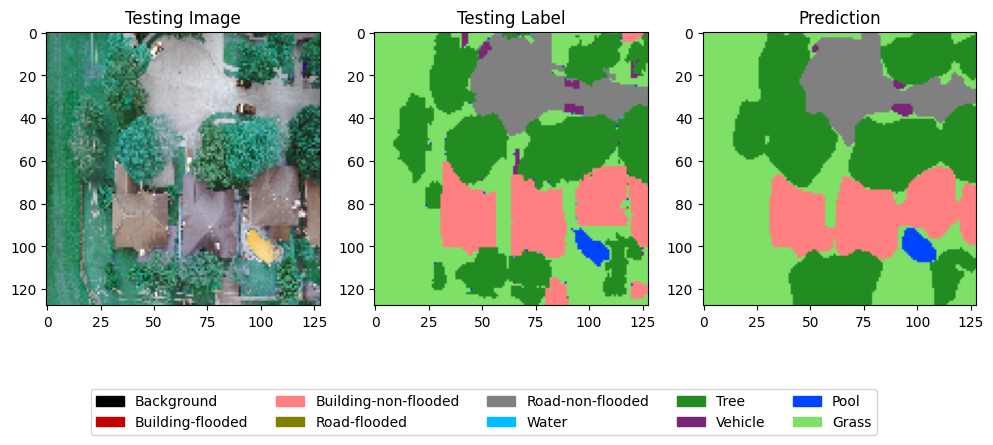

In [27]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)
IoU for this image: 0.99951171875


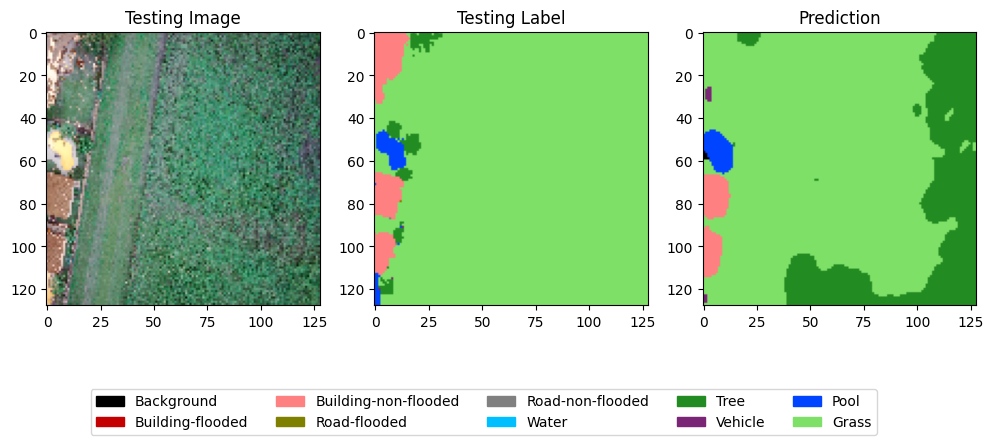

In [28]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)
IoU for this image: 0.8977142857142857


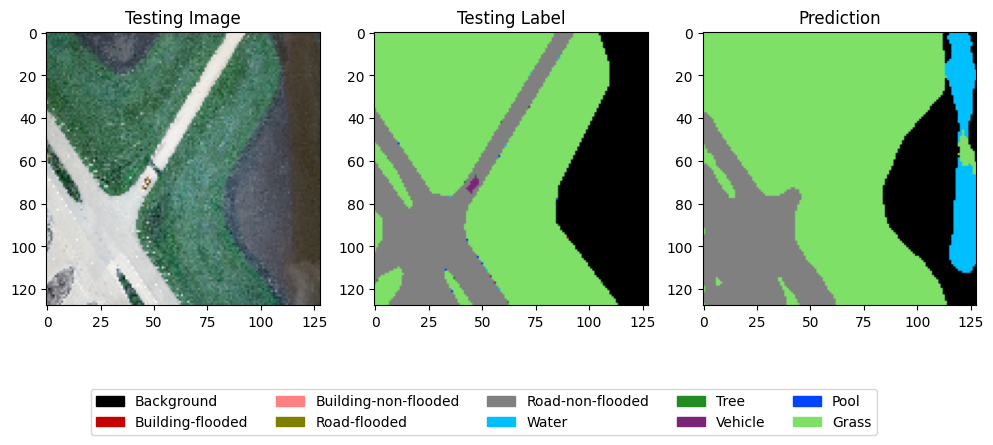

In [29]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)
IoU for this image: 1.0


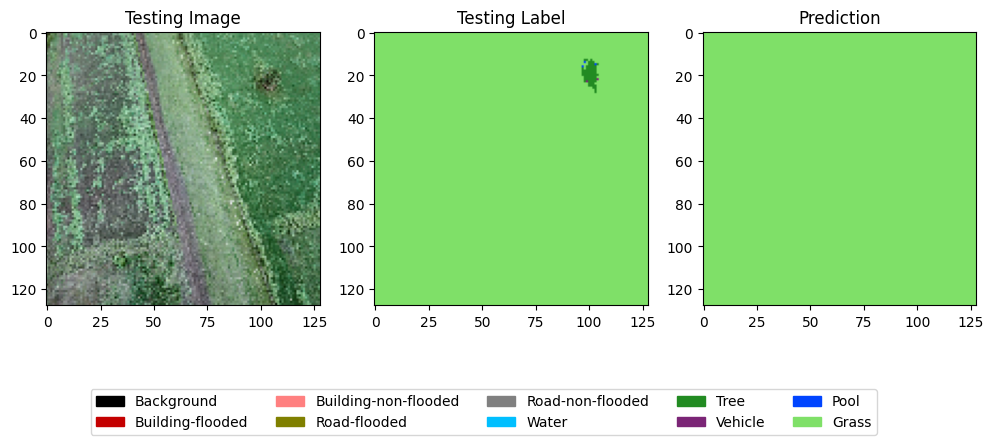

In [30]:
display_random_function()

Image Shape: (128, 128, 3)
Ground Truth Mask Shape: (128, 128)
Predicted Mask Shape: (128, 128)
IoU for this image: 0.63787841796875


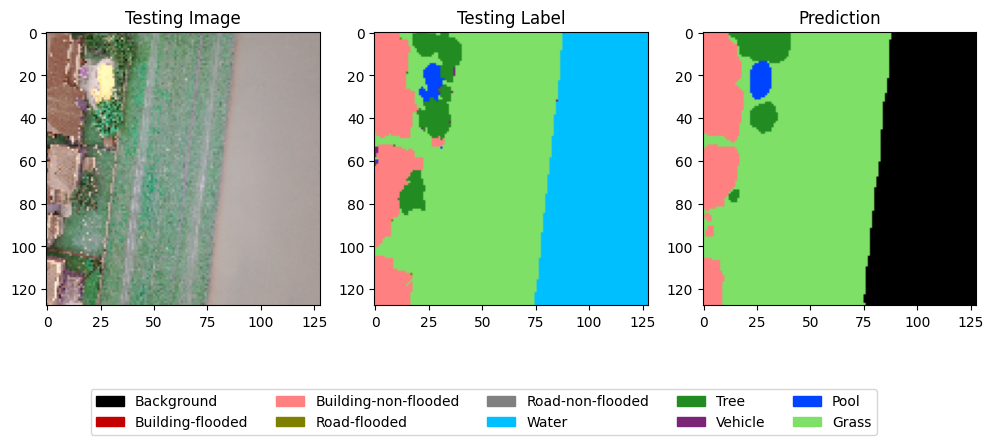

In [31]:
display_random_function()

# Error Analysis

25 : 0.28326416015625


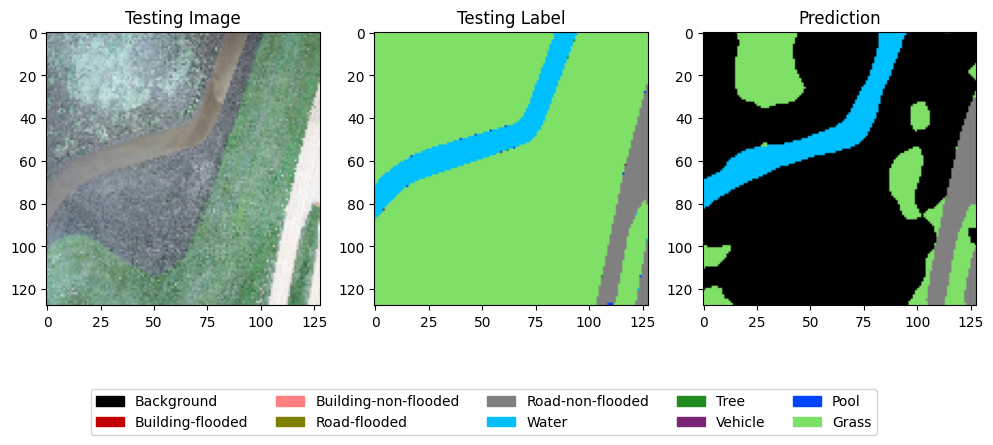

53 : 0.4888916015625


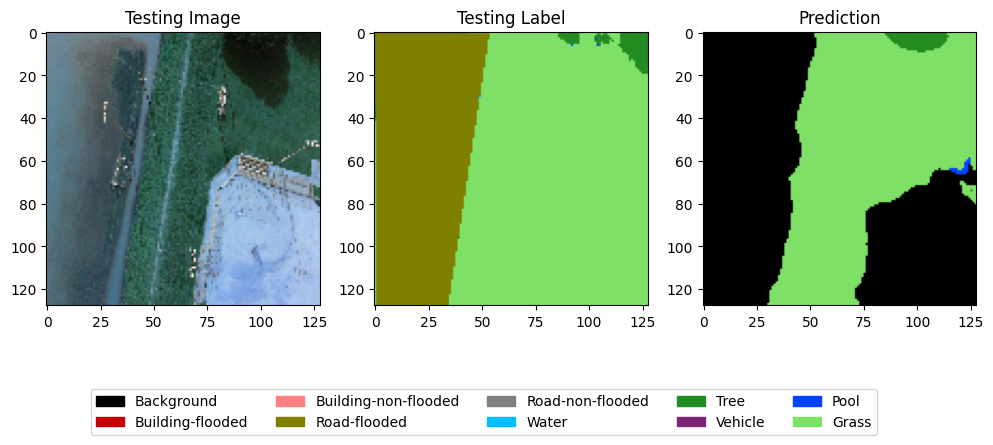

158 : 0.4501953125


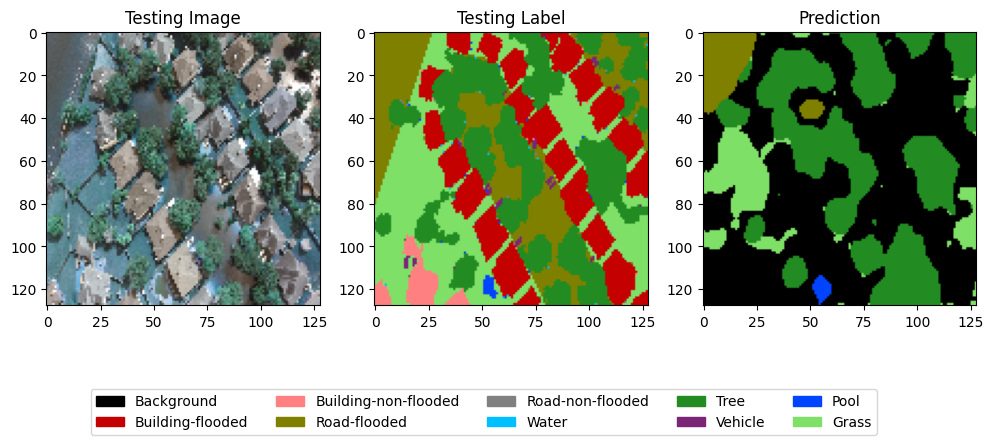

170 : 0.396484375


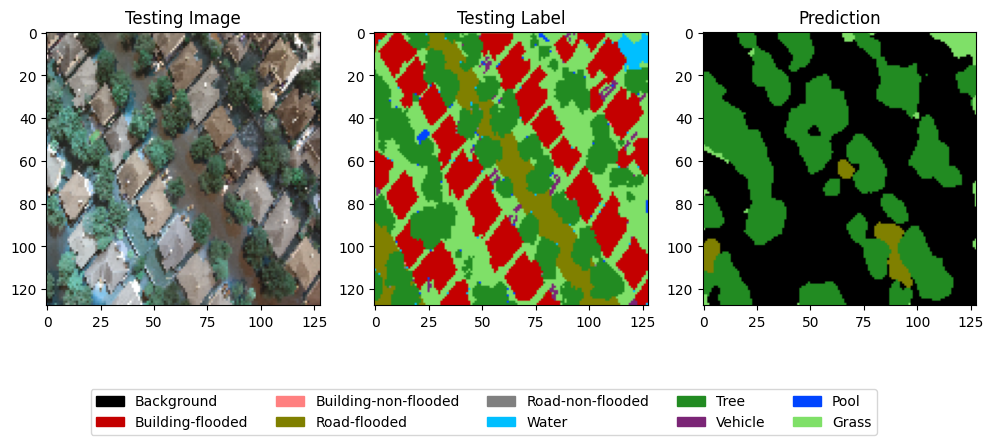

171 : 0.37713623046875


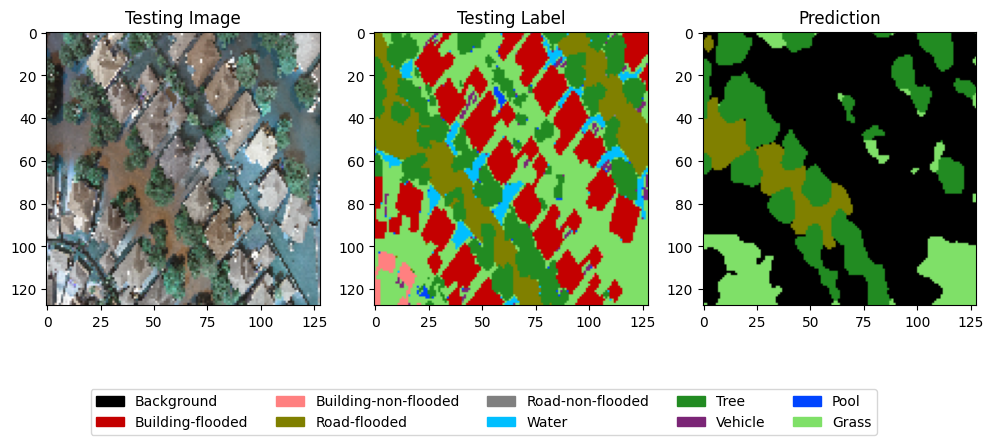

173 : 0.16783729310450132


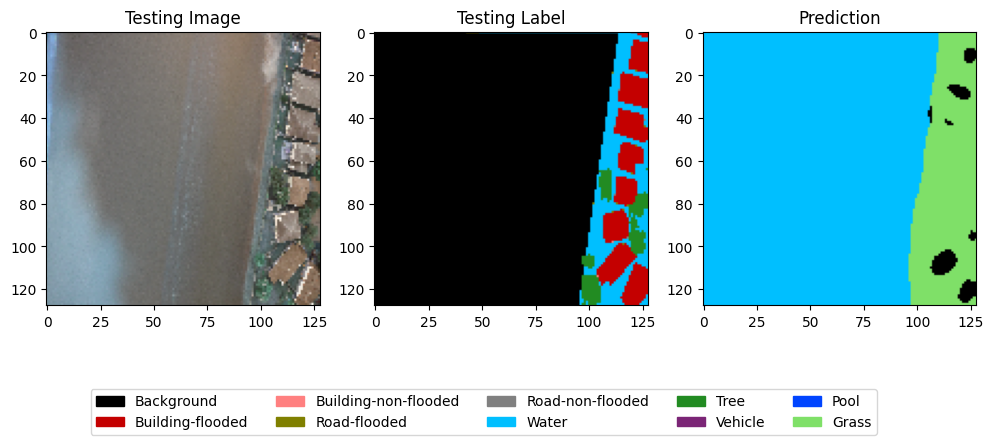

179 : 0.4761507545309775


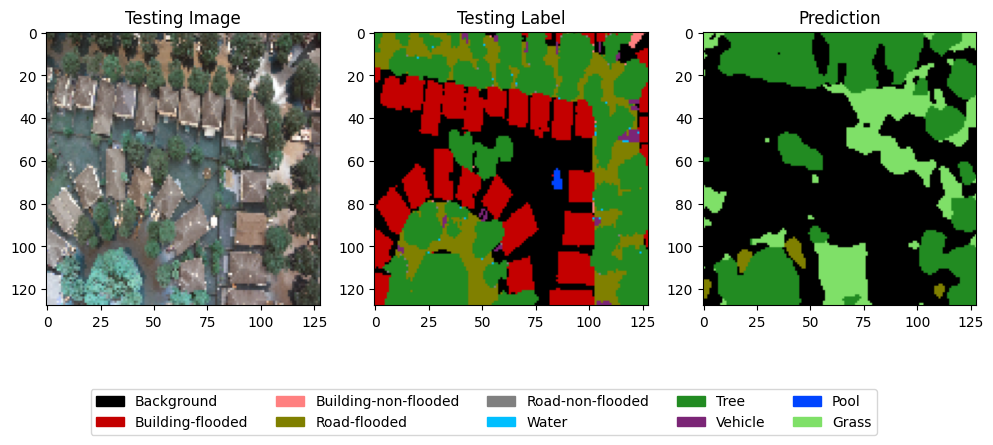

206 : 0.034653465346534656


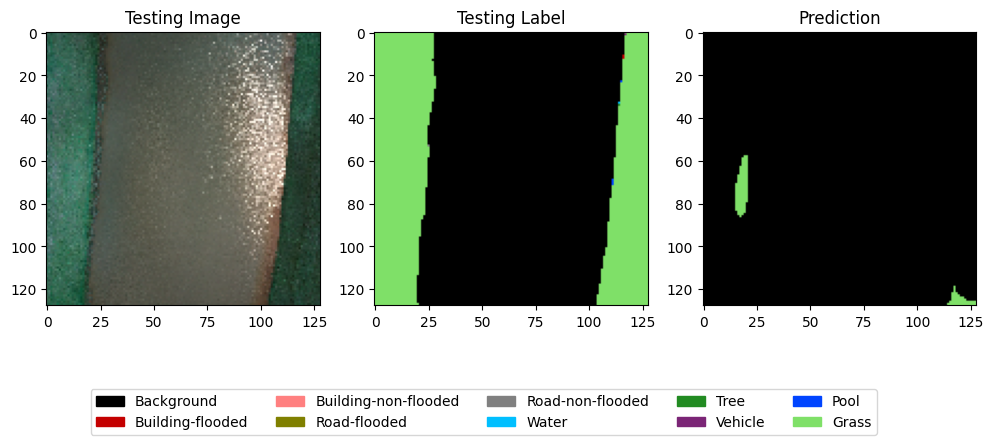

207 : 0.032708416433984845


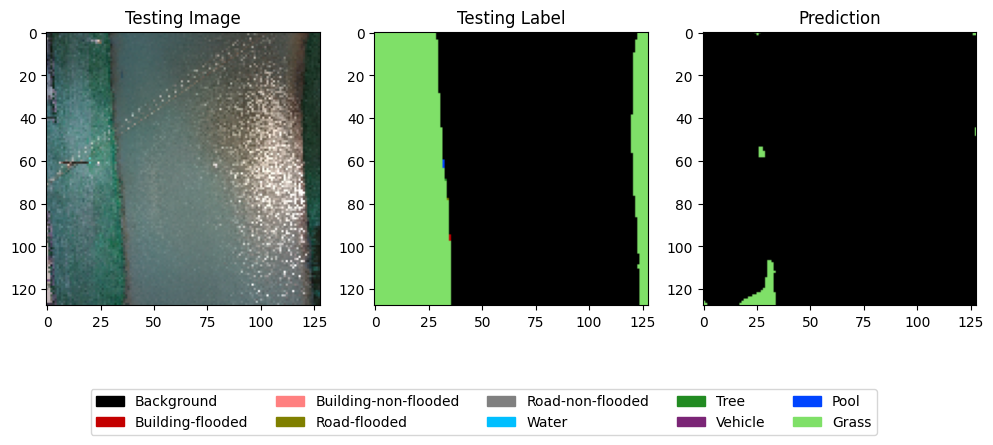

351 : 0.36041259765625


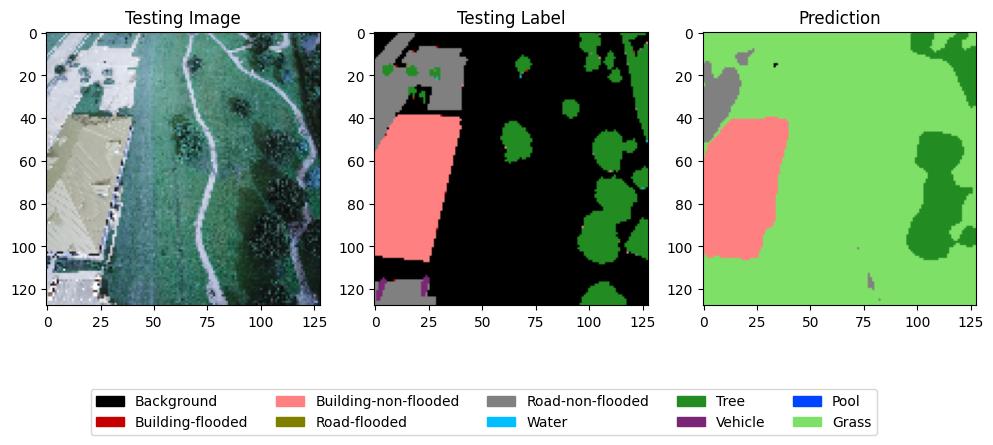

409 : 0.2152220851326342


In [ ]:
for i in range(len(test_images)):
    if iou_of_each_image[i] < 0.50:
        print(str(i) + " : " + str(iou_of_each_image[i]))
        display_images_with_masks(test_images_seperate[i], test_masks_[i], predicted_masks[i])